## Center estimates

Use IBTrACS as reference?

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem
from pyproj import Geod

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/05_PLOT_CENTERS/'
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

### 1) Paper Fig.

In [5]:
### a) Prepare center quality panel
dsg["qual"] = dsg.center_quality_flag.copy() * 0
dsg["qual"][dsg.center_quality_flag > 1] = 1
dsg["qual"][dsg.center_quality_flag > 2] = 2

geod                 = Geod(ellps='WGS84')
fwd_azimuth, _, dist = geod.inv(dsg.lon_ibt, dsg.lat_ibt, dsg.lon, dsg.lat)
x                    = (dist / 1000) * np.sin(np.deg2rad(fwd_azimuth))
y                    = (dist / 1000) * np.cos(np.deg2rad(fwd_azimuth))

quals   = [1, 2]
markers = ["o", "s", "^"]
colors  = ["m", "r", "darkblue"]

### b) Prepare SAR wind map panel

### c) Prepare GEO BT map panel

/tmp/ipykernel_19693/3279104134.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[dsg.qual == quals[kf]], y[dsg.qual == quals[kf]], marker=markers[kf], c=(1,1,1,0), edgecolors="k", s=60, label=r"1 < Q < 2")
/tmp/ipykernel_19693/3279104134.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[dsg.qual == quals[kf]], y[dsg.qual == quals[kf]], marker=markers[kf], c=(1,1,1,0), edgecolors="k", s=60, labe

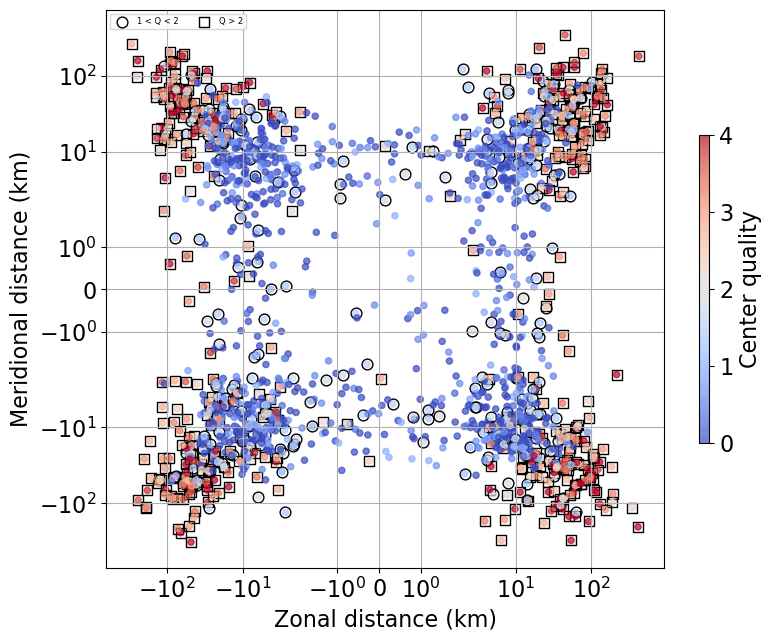

In [6]:
# Plot
fig,ax = plt.subplots(figsize=(9, 8))

# Plot empty squares and circles
# for kf in range(0,len(quals)):
kf = 0
ax.scatter(x[dsg.qual == quals[kf]], y[dsg.qual == quals[kf]], marker=markers[kf], c=(1,1,1,0), edgecolors="k", s=60, label=r"1 < Q < 2")
kf = 1
ax.scatter(x[dsg.qual == quals[kf]], y[dsg.qual == quals[kf]], marker=markers[kf], c=(1,1,1,0), edgecolors="k", s=60, label="Q > 2")
c = ax.scatter(x, y, marker="o", c=dsg.center_quality_flag, cmap="coolwarm", vmax=4, alpha=0.7, s=20)

ax.legend(loc="upper left", ncol=2, fontsize=6)
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlabel("Zonal distance (km)")
ax.set_ylabel("Meridional distance (km)")
ax.set_box_aspect(1)
fig.colorbar(c, aspect=30, shrink=0.5, label="Center quality")
ax.grid(True)

# # Save
# plt.savefig(PTHS['sav_dir'] + 'center_quality.png', bbox_inches='tight')

In [7]:
# All cases
geod = Geod(ellps='WGS84') 
fwd_az, bak_az, dist_m = geod.inv(dsg.lon_ibt, dsg.lat_ibt, dsg.lon, dsg.lat)
print(np.sqrt(np.nanmean(dist_m ** 2)))

59802.46883431032


In [8]:
# Filtered cases (q = 0)
geod = Geod(ellps='WGS84') 
fwd_az, bak_az, dist_m = geod.inv(dsg.lon_ibt[dsg.qual == 0], dsg.lat_ibt[dsg.qual == 0], dsg.lon[dsg.qual == 0], dsg.lat[dsg.qual == 0])
print(np.sqrt(np.nanmean(dist_m ** 2)))

20216.03554567085


In [17]:
# Best half
print(np.sqrt(np.nanmean(dist_m[dist_m < np.nanmedian(dist_m)] ** 2)))

8502.179107570912


In [20]:
# Best third quarters
print(np.sqrt(np.nanmean(dist_m[dist_m < np.nanquantile(dist_m, 0.75)] ** 2)))

11597.134068623502


### Case Study Numbers

In [19]:
ds = dsg.where(dsg.name == 'KIRK', drop=True).isel(time=-6)
print(ds.file_tcva.item())
float(ds.lon), float(ds.lat)

rcm1-sclnc-owi-ca-20241004t212518-20241004t212636-00003-______sw_al122024_cyclone_polar.nc


(-49.62053128907449, 23.823029342928223)

In [20]:
float(ds.lon_ibt), float(ds.lat_ibt)

(-49.44325141477914, 23.87208256854499)

In [21]:
float(ds.vws_pmd), float(ds.wsd_pmd)

(9.03807703812917, 70.64717173576355)

In [24]:
fwd_az, bak_az, dist_m = geod.inv(ds.lon_ibt, ds.lat_ibt, ds.lon, ds.lat)
print(dist_m)

18859.22866874672


In [44]:
# Angle to go from (lon, lat) to (lon_ibt, lat_ibt)
print(bak_az)

73.22121789171537


In [50]:
tilt = np.arctan2(18859.22866874672, 15954.41400201024)
print(np.rad2deg(tilt))

49.7696527264458


### 2) Tests

In [4]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34) # Distance to coast
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

501


Text(0, 0.5, 'Latitude diff (BTK - SAR, °N)')

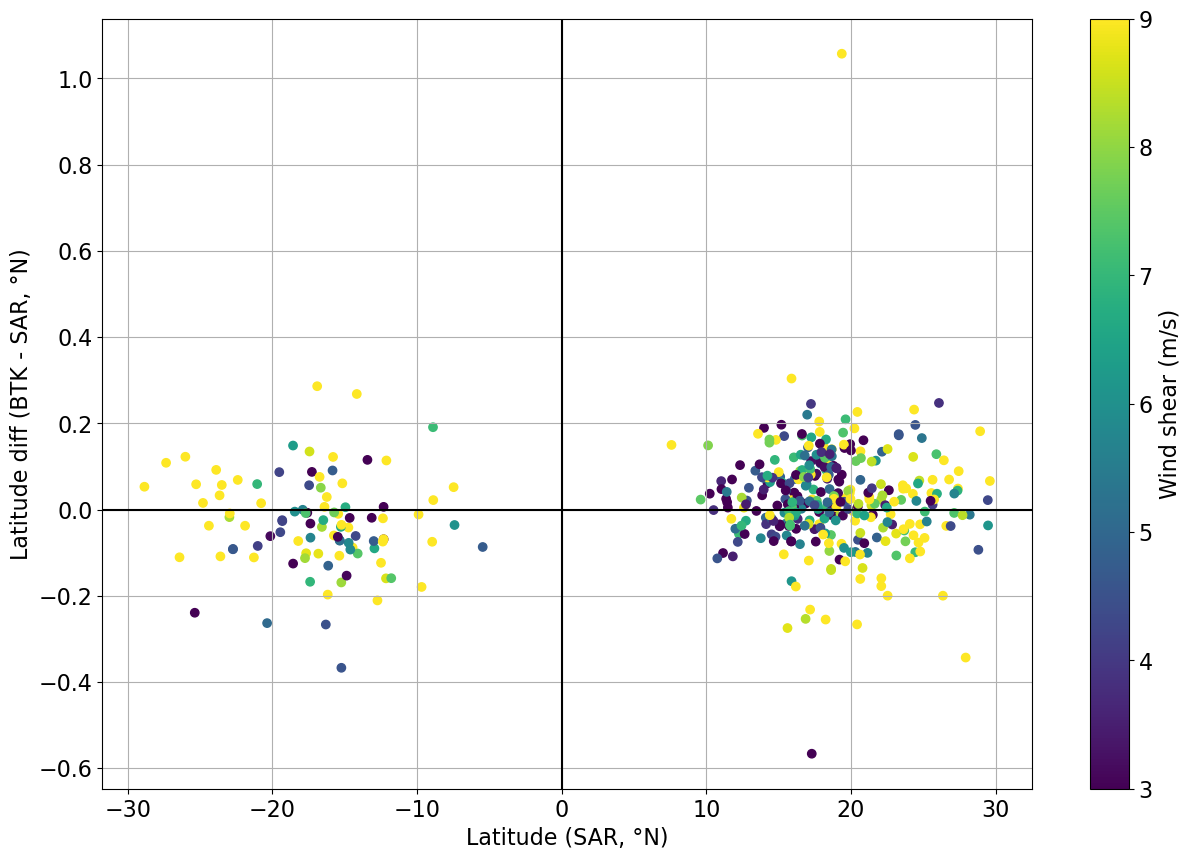

In [5]:
plt.scatter(d.lat, d.lat_ibt - d.lat, c=d.vws_pmd, vmin=3, vmax=9)
plt.colorbar(label='Wind shear (m/s)')
plt.grid()
plt.axhline(c='k');plt.axvline(c='k')
plt.xlabel('Latitude (SAR, °N)')
plt.ylabel('Latitude diff (BTK - SAR, °N)')

### WP

#### Lon

In [6]:
dwp = d.where(d.id.str[:2] == 'wp', drop=True)

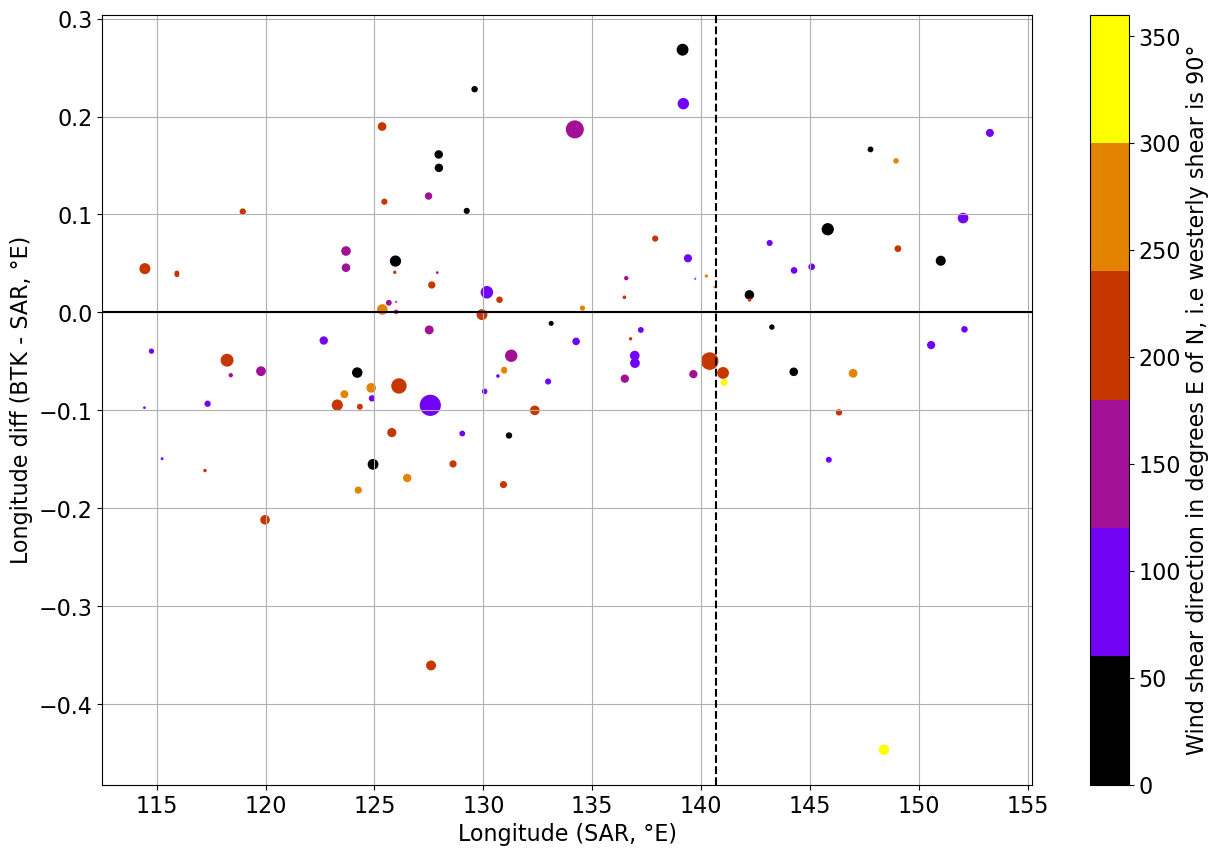

In [7]:
plt.scatter(dwp.lon, dwp.lon_ibt - dwp.lon, c=dwp.wsd_pmd, s=dwp.vws_pmd ** 2 * 0.5, cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Wind shear direction in degrees E of N, i.e westerly shear is 90°')
plt.axhline(c='k')
plt.axvline(140.7, c='k', linestyle='dashed')
plt.xlabel('Longitude (SAR, °E)')
plt.ylabel('Longitude diff (BTK - SAR, °E)')
plt.grid()

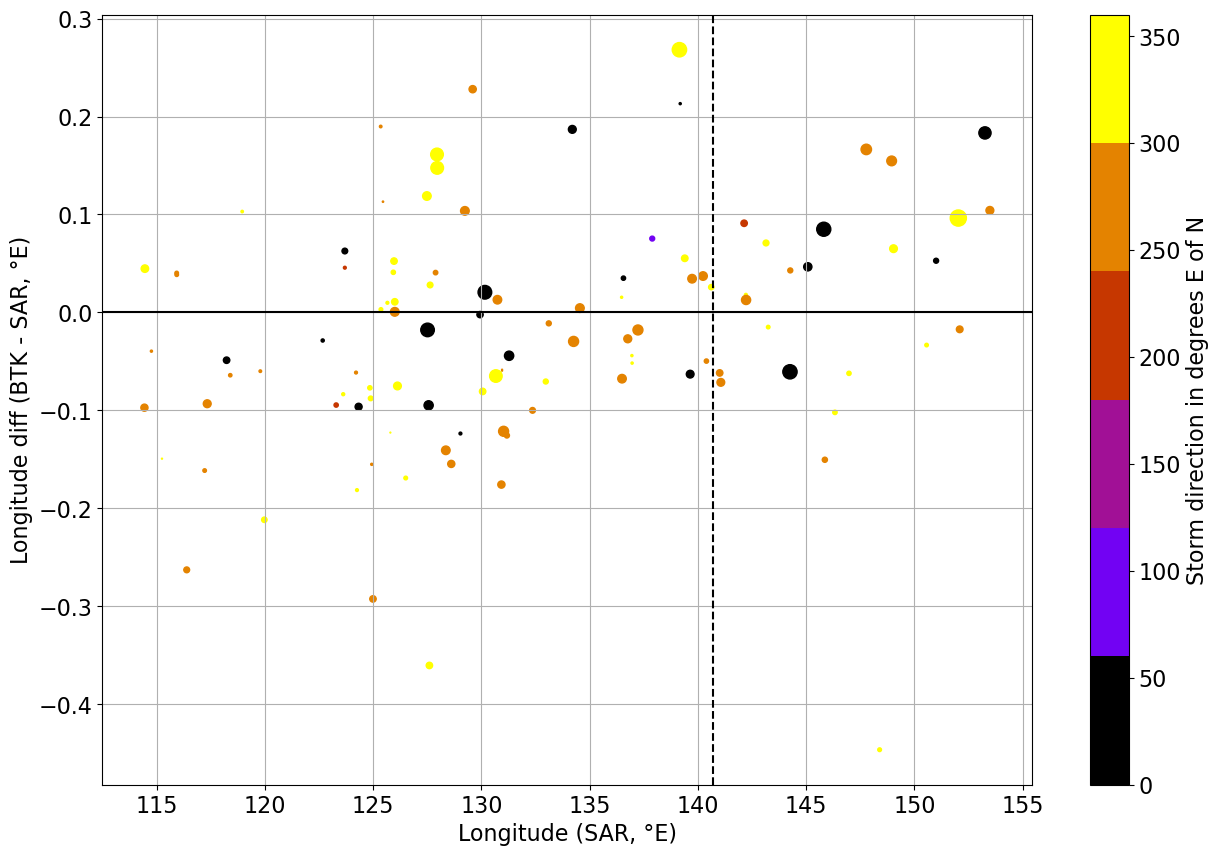

In [8]:
plt.scatter(dwp.lon, dwp.lon_ibt - dwp.lon, c=dwp.storm_dir_ibt, s=dwp.storm_speed_ibt ** 2 , cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Storm direction in degrees E of N')
plt.axhline(c='k')
plt.axvline(140.7, c='k', linestyle='dashed')
plt.xlabel('Longitude (SAR, °E)')
plt.ylabel('Longitude diff (BTK - SAR, °E)')
plt.grid()

#### Lat

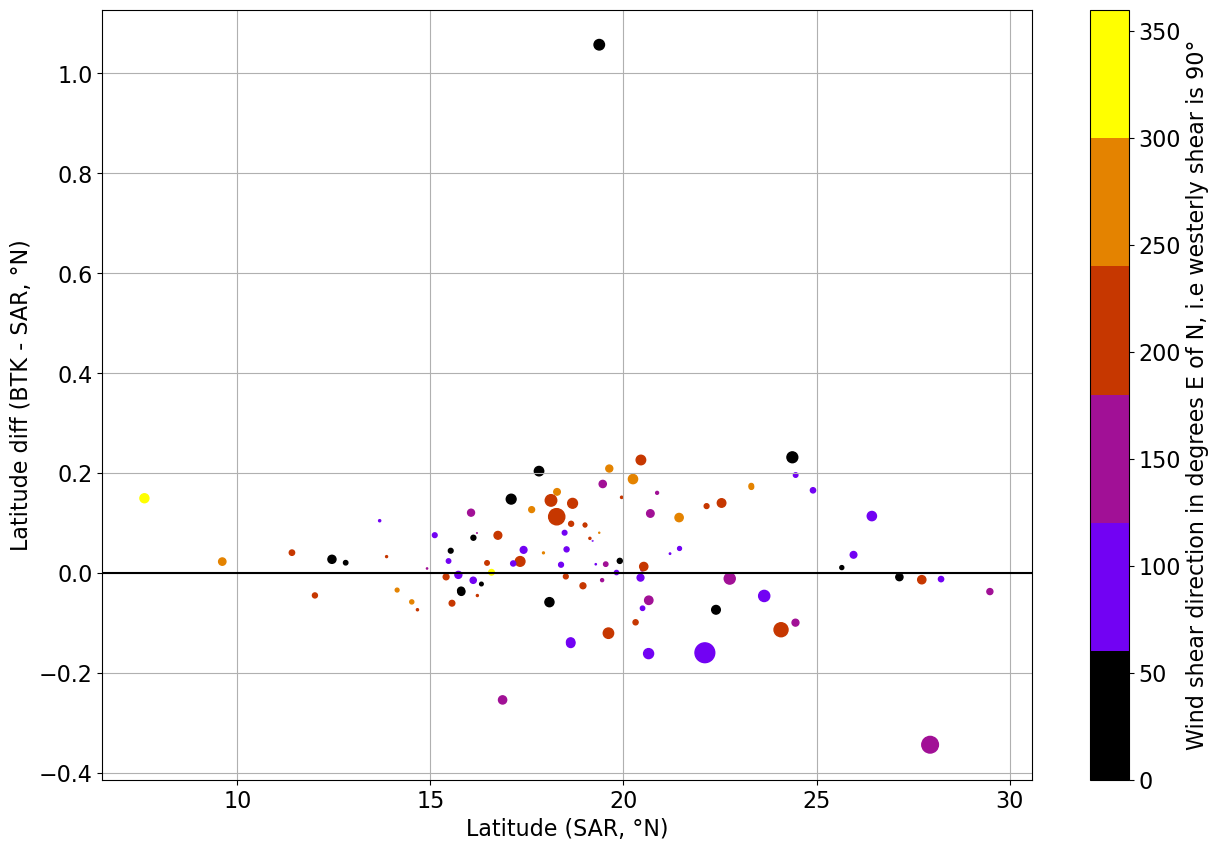

In [9]:
plt.scatter(dwp.lat, dwp.lat_ibt - dwp.lat, c=dwp.wsd_pmd, s=dwp.vws_pmd ** 2 * 0.5, cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Wind shear direction in degrees E of N, i.e westerly shear is 90°')
plt.axhline(c='k')
# plt.axvline(140.7, c='k', linestyle='dashed')
plt.xlabel('Latitude (SAR, °N)')
plt.ylabel('Latitude diff (BTK - SAR, °N)')
plt.grid()

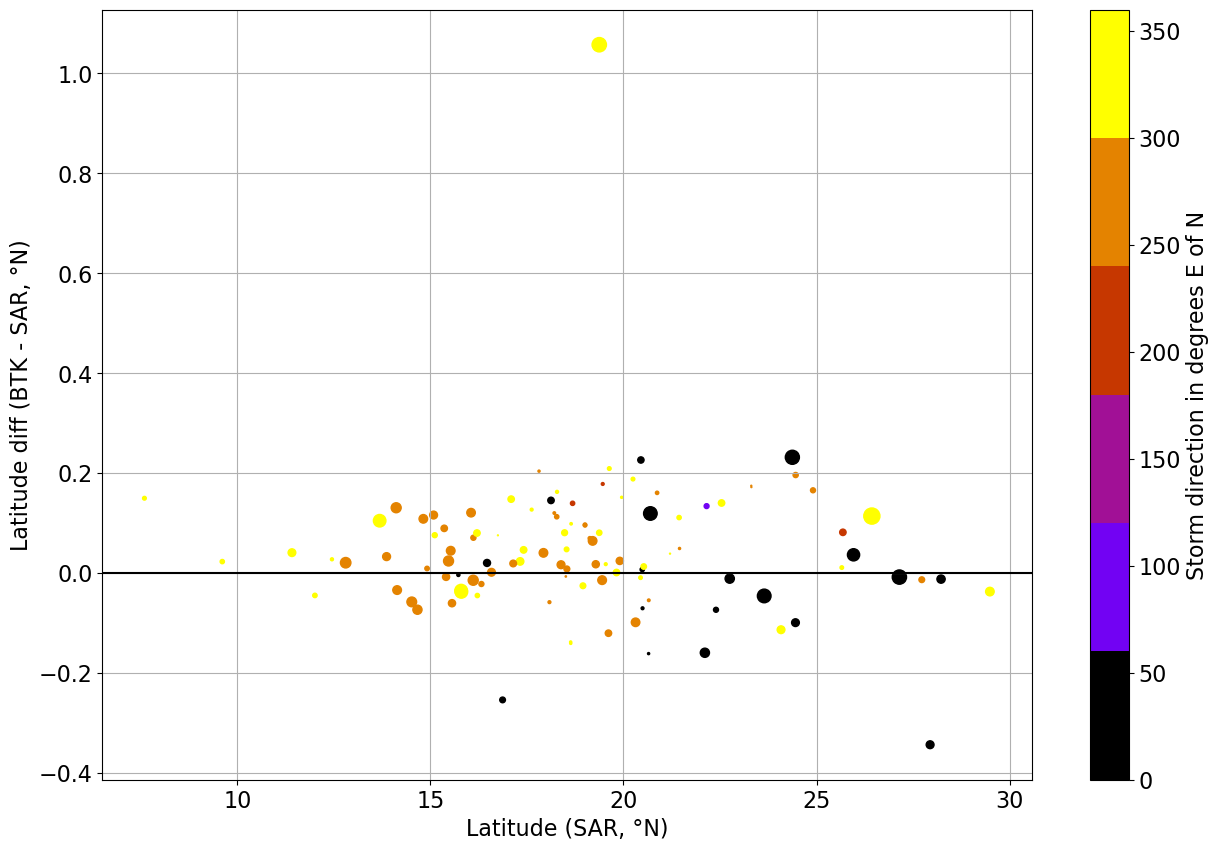

In [10]:
plt.scatter(dwp.lat, dwp.lat_ibt - dwp.lat, c=dwp.storm_dir_ibt, s=dwp.storm_speed_ibt ** 2 , cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Storm direction in degrees E of N')
plt.axhline(c='k')
# plt.axvline(140.7, c='k', linestyle='dashed')
plt.xlabel('Latitude (SAR, °N)')
plt.ylabel('Latitude diff (BTK - SAR, °N)')
plt.grid()

### EP

#### Lon

In [11]:
dep = d.where(d.id.str[:2] == 'ep', drop=True)

(-180.0, -80.0)

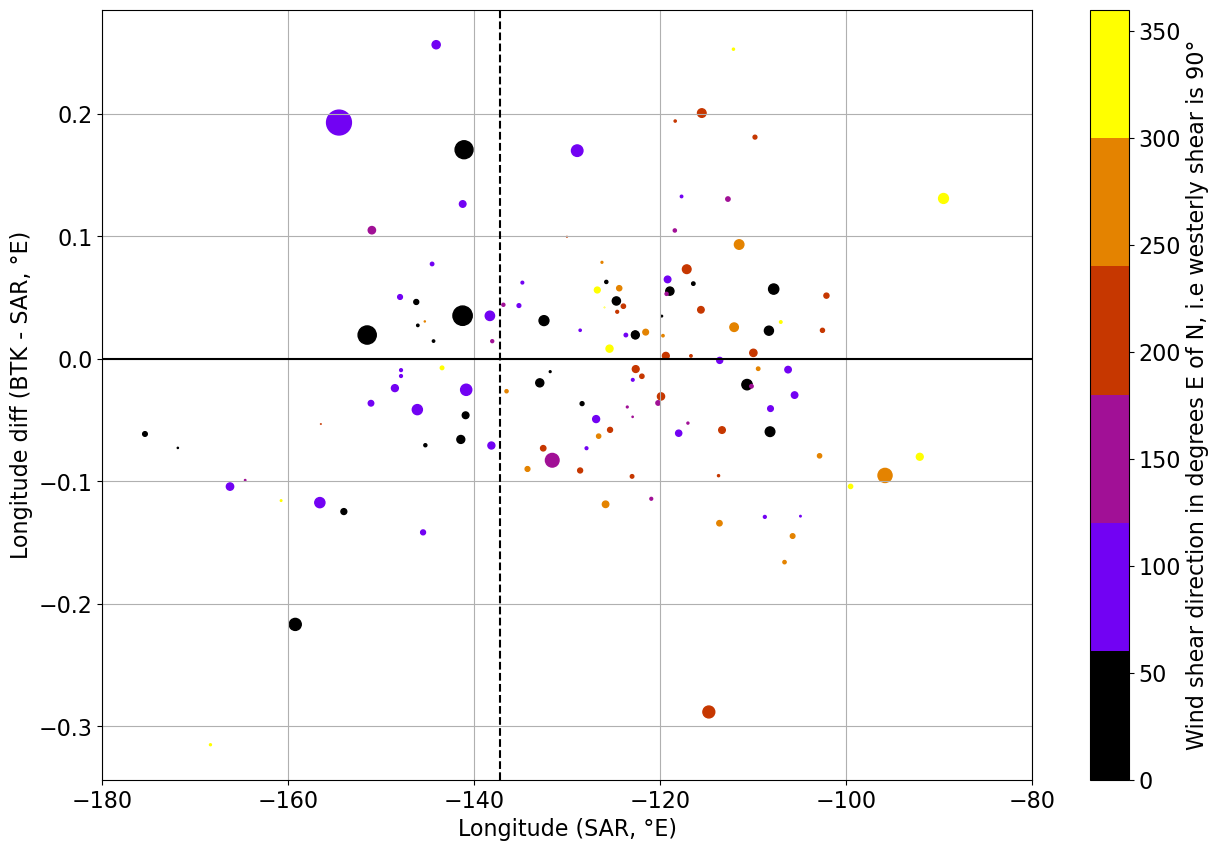

In [12]:
plt.scatter(dep.lon, dep.lon_ibt - dep.lon, c=dep.wsd_pmd, s=dep.vws_pmd ** 2 * 0.5, cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Wind shear direction in degrees E of N, i.e westerly shear is 90°')
plt.axhline(c='k')
plt.axvline(-137.2, c='k', linestyle='dashed')
plt.xlabel('Longitude (SAR, °E)')
plt.ylabel('Longitude diff (BTK - SAR, °E)')
plt.grid()
plt.xlim(-180, -80)

(-180.0, -80.0)

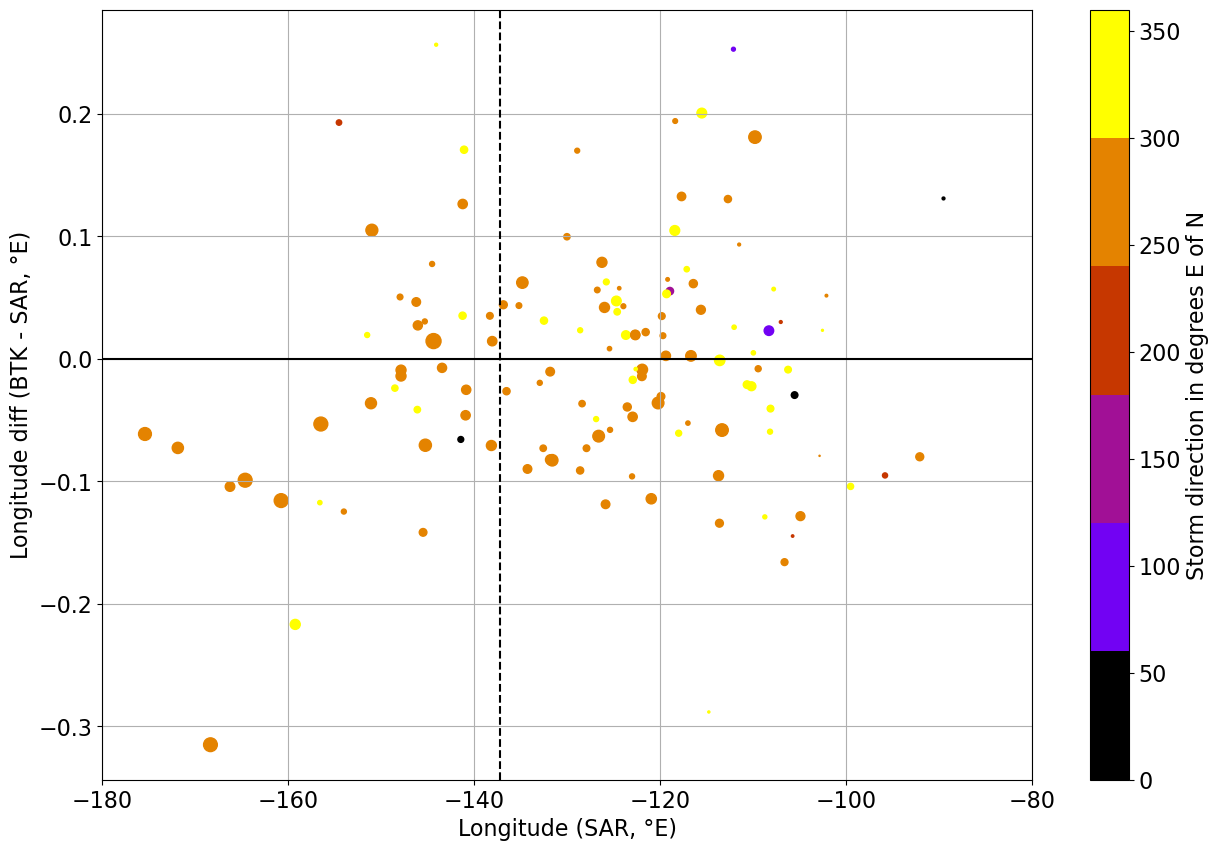

In [13]:
plt.scatter(dep.lon, dep.lon_ibt - dep.lon, c=dep.storm_dir_ibt, s=dep.storm_speed_ibt ** 2 , cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Storm direction in degrees E of N')
plt.axhline(c='k')
plt.axvline(-137.2, c='k', linestyle='dashed')
plt.xlabel('Longitude (SAR, °E)')
plt.ylabel('Longitude diff (BTK - SAR, °E)')
plt.grid()
plt.xlim(-180, -80)

#### Lat

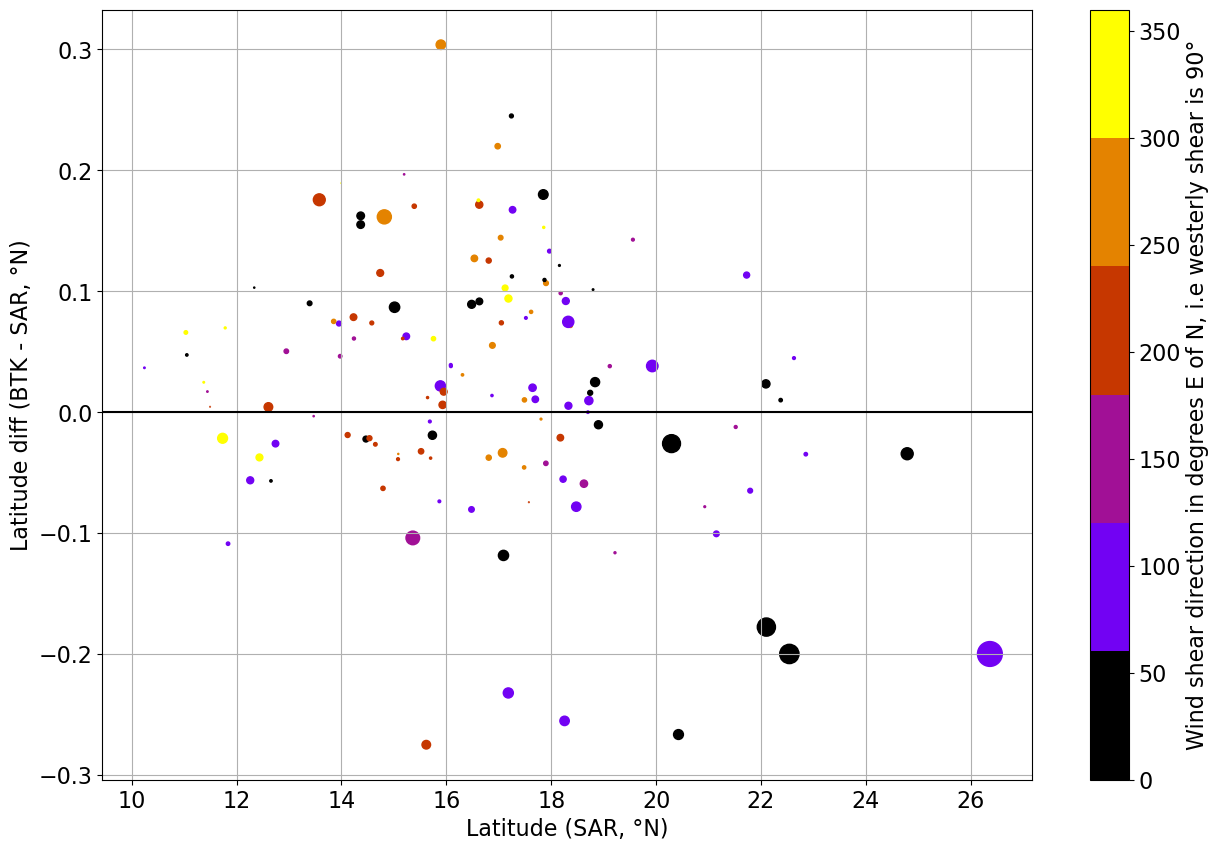

In [14]:
plt.scatter(dep.lat, dep.lat_ibt - dep.lat, c=dep.wsd_pmd, s=dep.vws_pmd ** 2 * 0.5, cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Wind shear direction in degrees E of N, i.e westerly shear is 90°')
plt.axhline(c='k')
# plt.axvline(-137.2, c='k', linestyle='dashed')
plt.xlabel('Latitude (SAR, °N)')
plt.ylabel('Latitude diff (BTK - SAR, °N)')
plt.grid()
# plt.xlim(-180, -80)

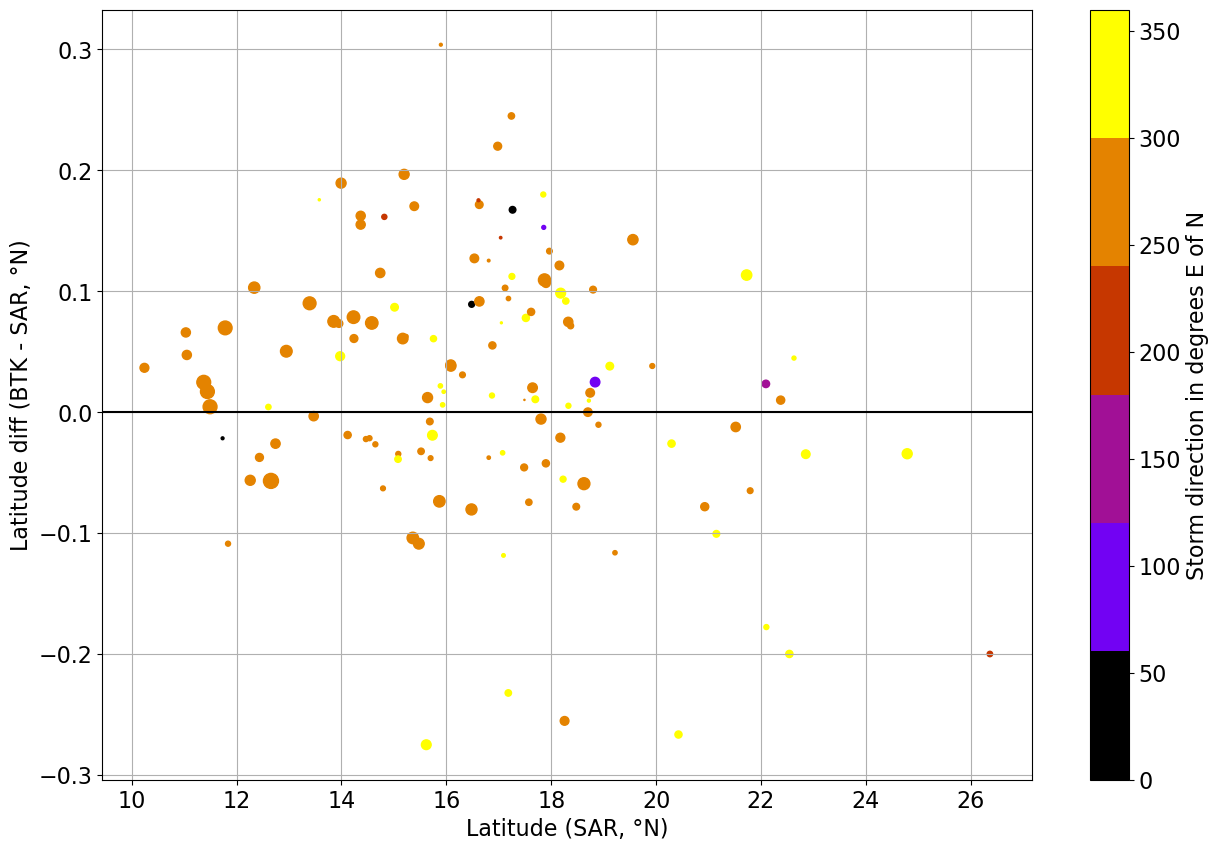

In [15]:
plt.scatter(dep.lat, dep.lat_ibt - dep.lat, c=dep.storm_dir_ibt, s=dep.storm_speed_ibt ** 2 , cmap=plt.get_cmap('gnuplot', 6), vmin=0, vmax=360)
plt.colorbar(label='Storm direction in degrees E of N')
plt.axhline(c='k')
# plt.axvline(-137.2, c='k', linestyle='dashed')
plt.xlabel('Latitude (SAR, °N)')
plt.ylabel('Latitude diff (BTK - SAR, °N)')
plt.grid()
# plt.xlim(-180, -80)

In [16]:
dep_           = dep.where((dep.lon < -105) & (dep.vws_pmd < 10), drop=True)
# dep_           = dep.where((dep.lon < -105) & (dep.storm_speed_ibt < 5), drop=True)
# dep_           = dep.where((dep.lon < -105) & (dep.storm_speed_ibt < 5) & (dep.vws_pmd < 5), drop=True)
dep_fthr_north = dep_.where(dep_.lat_ibt - dep_.lat > 0, drop=True)
dep_fthr_south = dep_.where(dep_.lat_ibt - dep_.lat < 0, drop=True)

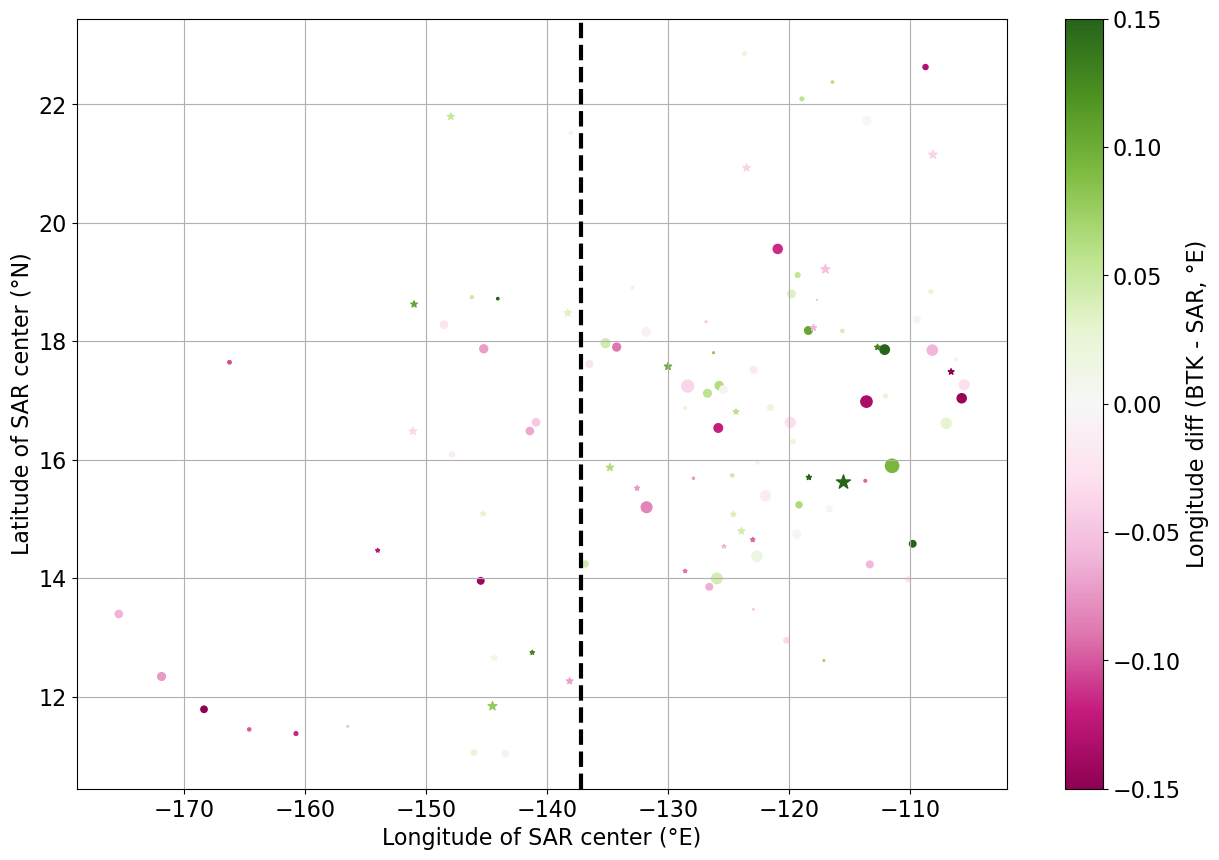

In [17]:
plt.scatter(dep_fthr_north.lon, dep_fthr_north.lat, c=dep_fthr_north.lon_ibt - dep_fthr_north.lon, s=300 *    (dep_fthr_north.lat_ibt - dep_fthr_north.lat),             cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.scatter(dep_fthr_south.lon, dep_fthr_south.lat, c=dep_fthr_south.lon_ibt - dep_fthr_south.lon, s=400 * abs(dep_fthr_south.lat_ibt - dep_fthr_south.lat), marker='*', cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.colorbar(label='Longitude diff (BTK - SAR, °E)')
plt.axvline(-137.2, c='k', linestyle='dashed', linewidth=3)
plt.xlabel('Longitude of SAR center (°E)')
plt.ylabel('Latitude of SAR center (°N)')
plt.grid()
# plt.xlim(-180, -80)

In [18]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lat

<xarray.DataArray 'lat' (time: 3)> Size: 24B
array([18.7183718 , 17.85784188, 14.57917168])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:    Latitude of the storm SAR center
    description:  Based on Vinour et al., 2021 (JAS) method 
    units:        degrees_north

In [19]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lon

<xarray.DataArray 'lon' (time: 3)> Size: 24B
array([-144.08451678, -112.11891757, -109.80389265])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:    Longitude of the storm SAR center
    description:  Based on Vinour et al., 2021 (JAS) method 
    units:        degrees_east

In [20]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 3)> Size: 24B
array(['rs2--owi-ca-20150903t152310-20150903t152714-00003-______sw_ep132015_cyclone_polar.nc',
       'rcm2-sc50mc-owi-ca-20231009t131944-20231009t132100-00003-______sw_ep152023_cyclone_polar.nc',
       'rcm1-sc50mb-owi-ca-20241023t012355-20241023t012513-00003-______sw_ep122024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [21]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).center_quality_flag

<xarray.DataArray 'center_quality_flag' (time: 3)> Size: 24B
array([0. , 1.3, 0.7])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:      aggregated flag indicating general center quality
    description:    Taken from Ifremer TCVA product
    flag_values:    0 1 2
    flag_meanings:  good warning bad

In [22]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lon_ibt - dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lon

<xarray.DataArray (time: 3)> Size: 24B
array([0.25651415, 0.25286338, 0.18106166])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...

In [23]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lat_ibt - dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).lat

<xarray.DataArray (time: 3)> Size: 24B
array([0.00962881, 0.15286186, 0.07384692])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...

In [24]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).vws_pmd

<xarray.DataArray 'vws_pmd' (time: 3)> Size: 24B
array([8.28094517, 2.17310779, 3.90100226])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:              Magnitude of the layered vertical wind shear vector
    units:                  m s-1
    coverage_content_type:  modelResult
    regions:                0_to_300_km 0_to_500_km 0_to_800_km 200_to_800_km
    layer:                  850_to_500_hPa 850_to_200_hPa
    SHIPS_related_label:    SHRS SHDC SHRD
    valid_range:            [-32767  32767]

In [25]:
dep_fthr_north.where((dep_fthr_north.lon_ibt - dep_fthr_north.lon) > 0.15, drop=True).speed

<xarray.DataArray 'speed' (time: 3)> Size: 24B
array([1.32984075, 3.18961892, 8.90370865])
Coordinates:
  * time     (time) datetime64[ns] 24B 2015-09-03T15:25:12 ... 2024-10-23T01:...
Attributes:
    long_name:    Estimated cyclone propagation speed
    description:  Taken from Ifremer TCVA product
    units:        m/s

### North Atlantic

In [26]:
dal = d.where(d.id.str[:2] == 'al', drop=True)

In [27]:
dal_           = dal.where((dal.vws_pmd < 10), drop=True)
# dal_           = dal.where((dal.storm_speed_ibt < 5), drop=True)
# dal_           = dal.where((dal.storm_speed_ibt < 5) & (dal.vws_pmd < 5), drop=True)
dal_fthr_north = dal_.where(dal_.lat_ibt - dal_.lat > 0, drop=True)
dal_fthr_south = dal_.where(dal_.lat_ibt - dal_.lat < 0, drop=True)

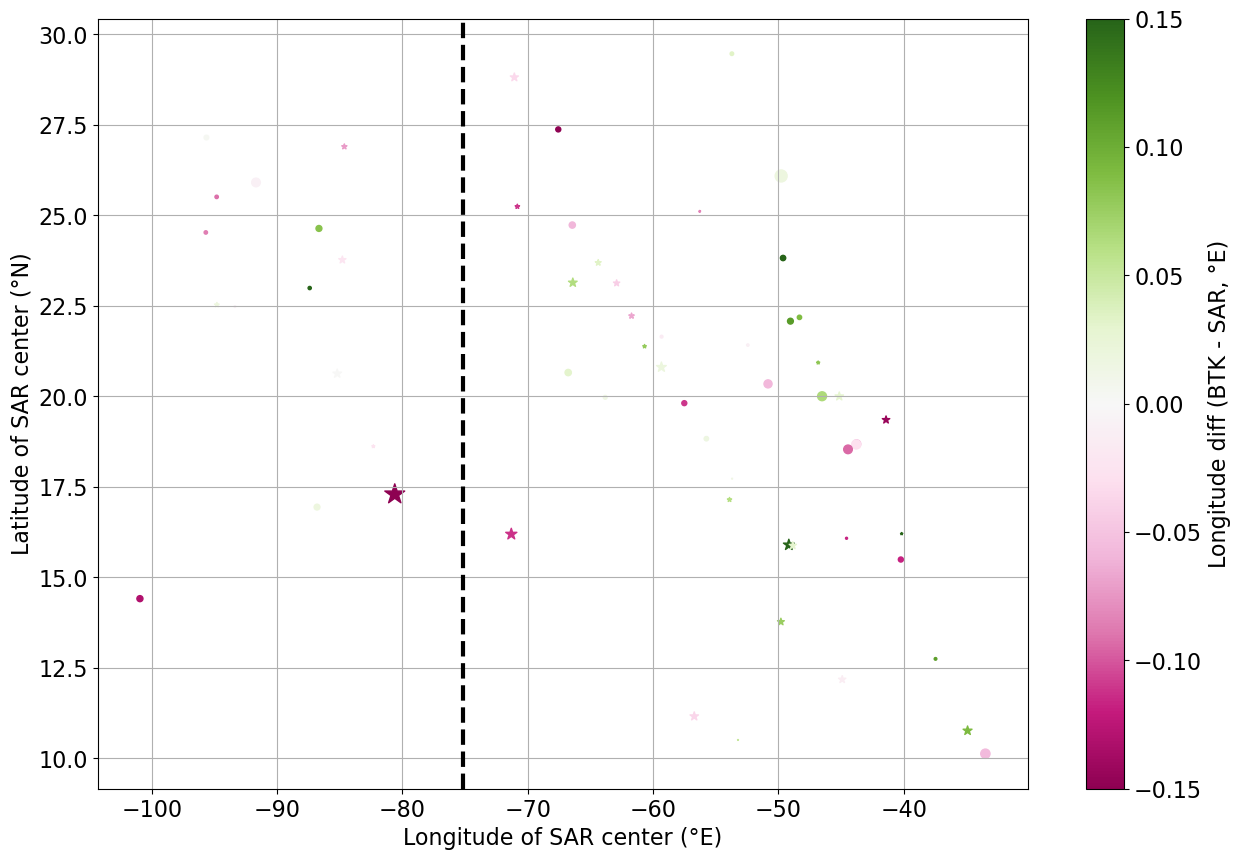

In [28]:
plt.scatter(dal_fthr_north.lon, dal_fthr_north.lat, c=dal_fthr_north.lon_ibt - dal_fthr_north.lon, s=300 *    (dal_fthr_north.lat_ibt - dal_fthr_north.lat),             cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.scatter(dal_fthr_south.lon, dal_fthr_south.lat, c=dal_fthr_south.lon_ibt - dal_fthr_south.lon, s=400 * abs(dal_fthr_south.lat_ibt - dal_fthr_south.lat), marker='*', cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.colorbar(label='Longitude diff (BTK - SAR, °E)')
plt.axvline(-75.2, c='k', linestyle='dashed', linewidth=3)
plt.xlabel('Longitude of SAR center (°E)')
plt.ylabel('Latitude of SAR center (°N)')
plt.grid()
# plt.xlim(-180, -80)

In [29]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lat

<xarray.DataArray 'lat' (time: 2)> Size: 16B
array([23.82302934, 22.99348844])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:    Latitude of the storm SAR center
    description:  Based on Vinour et al., 2021 (JAS) method 
    units:        degrees_north

In [30]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lon

<xarray.DataArray 'lon' (time: 2)> Size: 16B
array([-49.62053129, -87.39757165])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:    Longitude of the storm SAR center
    description:  Based on Vinour et al., 2021 (JAS) method 
    units:        degrees_east

In [31]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 2)> Size: 16B
array(['rcm1-sclnc-owi-ca-20241004t212518-20241004t212636-00003-______sw_al122024_cyclone_polar.nc',
       'rcm3-sclnd-owi-ca-20241009t000624-20241009t000741-00003-______sw_al142024_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [32]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).center_quality_flag

<xarray.DataArray 'center_quality_flag' (time: 2)> Size: 16B
array([0.  , 0.85])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:      aggregated flag indicating general center quality
    description:    Taken from Ifremer TCVA product
    flag_values:    0 1 2
    flag_meanings:  good warning bad

In [33]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lon_ibt - dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lon

<xarray.DataArray (time: 2)> Size: 16B
array([0.17727987, 0.51710716])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02

In [34]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lat_ibt - dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).lat

<xarray.DataArray (time: 2)> Size: 16B
array([0.04905323, 0.01823375])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02

In [35]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).vws_pmd

<xarray.DataArray 'vws_pmd' (time: 2)> Size: 16B
array([9.03807704, 9.01540121])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:              Magnitude of the layered vertical wind shear vector
    units:                  m s-1
    coverage_content_type:  modelResult
    regions:                0_to_300_km 0_to_500_km 0_to_800_km 200_to_800_km
    layer:                  850_to_500_hPa 850_to_200_hPa
    SHIPS_related_label:    SHRS SHDC SHRD
    valid_range:            [-32767  32767]

In [36]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).speed

<xarray.DataArray 'speed' (time: 2)> Size: 16B
array([5.76894473, 6.24561847])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:    Estimated cyclone propagation speed
    description:  Taken from Ifremer TCVA product
    units:        m/s

In [37]:
dal_fthr_north.where((dal_fthr_north.lon_ibt - dal_fthr_north.lon) > 0.15, drop=True).wsd_pmd

<xarray.DataArray 'wsd_pmd' (time: 2)> Size: 16B
array([70.64717174, 24.96217996])
Coordinates:
  * time     (time) datetime64[ns] 16B 2024-10-04T21:25:57 2024-10-09T00:07:02
Attributes:
    long_name:              Direction of the layered vertical wind shear vect...
    units:                  degree
    coverage_content_type:  modelResult
    regions:                0_to_300_km 0_to_500_km 0_to_800_km 200_to_800_km
    layer:                  850_to_500_hPa 850_to_200_hPa
    SHIPS_related_label:    SHTS SDDC SHTD
    valid_range:            [-32767  32767]

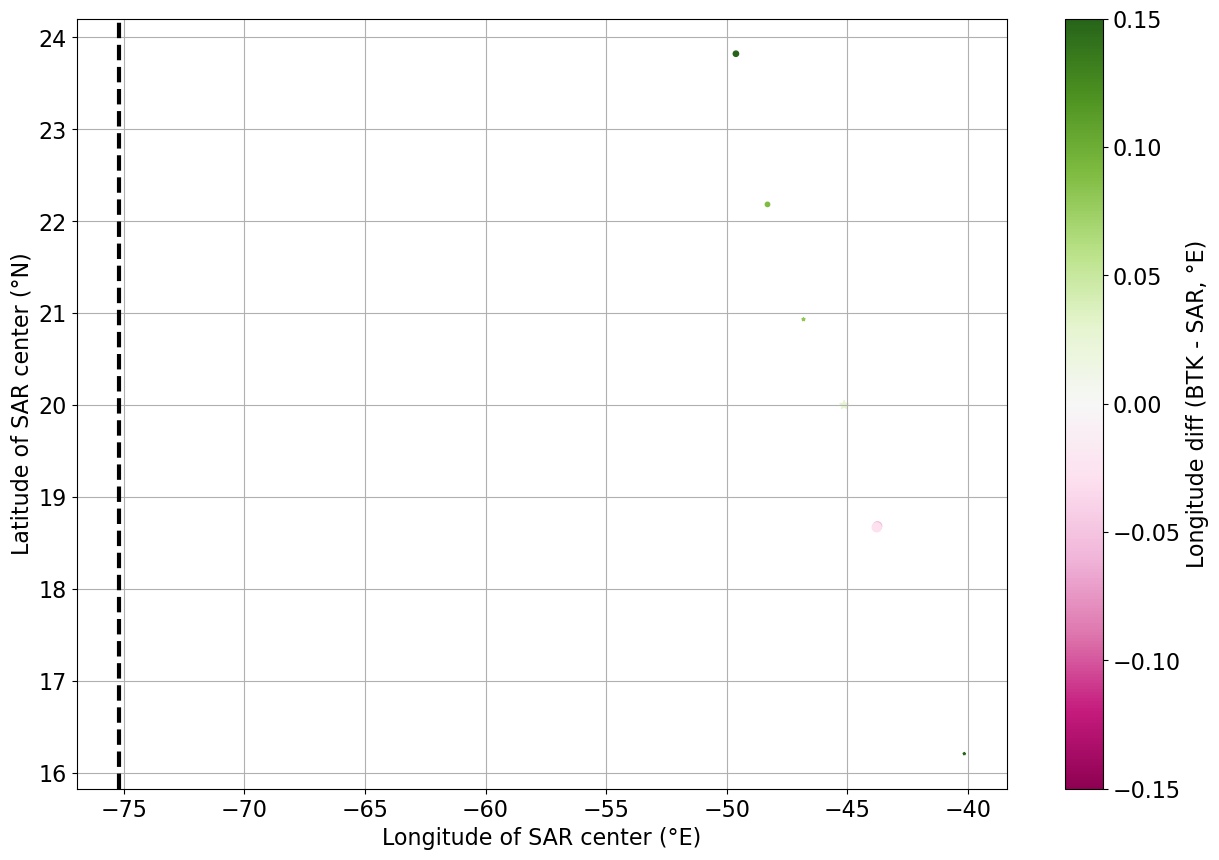

In [43]:
# Kirk 2024
tc_ = dal_.where(dal_.id == 'al122024', drop=True)
tc_fthr_north = tc_.where(dal_.lat_ibt - tc_.lat > 0, drop=True)
tc_fthr_south = tc_.where(dal_.lat_ibt - tc_.lat < 0, drop=True)

plt.scatter(tc_fthr_north.lon, tc_fthr_north.lat, c=tc_fthr_north.lon_ibt - tc_fthr_north.lon, s=300 *    (tc_fthr_north.lat_ibt - tc_fthr_north.lat),             cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.scatter(tc_fthr_south.lon, tc_fthr_south.lat, c=tc_fthr_south.lon_ibt - tc_fthr_south.lon, s=400 * abs(tc_fthr_south.lat_ibt - tc_fthr_south.lat), marker='*', cmap=plt.get_cmap('PiYG'), vmin=-0.15, vmax=0.15)
plt.colorbar(label='Longitude diff (BTK - SAR, °E)')
plt.axvline(-75.2, c='k', linestyle='dashed', linewidth=3)
plt.xlabel('Longitude of SAR center (°E)')
plt.ylabel('Latitude of SAR center (°N)')
plt.grid()
# plt.xlim(-180, -80)